# Plagiarism Text Data

In this project, you will be tasked with building a plagiarism detector that examines a text file and performs binary classification; labeling that file as either plagiarized or not, depending on how similar the text file is when compared to a provided source text. 

The first step in working with any dataset is loading the data in and noting what information is included in the dataset. This is an important step in eventually working with this data, and knowing what kinds of features you have to work with as you transform and group the data!

So, this notebook is all about exploring the data and noting patterns about the features you are given and the distribution of data. 

> There are not any exercises or questions in this notebook, it is only meant for exploration. This notebook will note be required in your final project submission.

---

## Read in the Data

The cell below will download the necessary data and extract the files into the folder `data/`.

This data is a slightly modified version of a dataset created by Paul Clough (Information Studies) and Mark Stevenson (Computer Science), at the University of Sheffield. You can read all about the data collection and corpus, at [their university webpage](https://ir.shef.ac.uk/cloughie/resources/plagiarism_corpus.html). 

> **Citation for data**: Clough, P. and Stevenson, M. Developing A Corpus of Plagiarised Short Answers, Language Resources and Evaluation: Special Issue on Plagiarism and Authorship Analysis, In Press. [Download]

In [10]:
# for some reason this line doesn't work but manually using the URL does work
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c4147f9_data/data.zip

--2020-07-03 10:11:02--  https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c4147f9_data/data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.138.45
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.138.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113826 (111K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 111.16K   702KB/s    in 0.2s    

2020-07-03 10:11:03 (702 KB/s) - ‘data.zip’ saved [113826/113826]



In [14]:
!unzip data

Archive:  data.zip
   creating: data/
  inflating: data/.DS_Store          
replace __MACOSX/data/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [12]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os

This plagiarism dataset is made of multiple text files; each of these files has characteristics that are is summarized in a `.csv` file named `file_information.csv`, which we can read in using `pandas`.

In [15]:
csv_file = 'data/file_information.csv'
plagiarism_df = pd.read_csv(csv_file)

# print out the first few rows of data info
plagiarism_df.head(10)

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non
5,g0pB_taska.txt,a,non
6,g0pB_taskb.txt,b,non
7,g0pB_taskc.txt,c,cut
8,g0pB_taskd.txt,d,light
9,g0pB_taske.txt,e,heavy


In [16]:
plagiarism_df.Category.value_counts()

non      38
light    19
cut      19
heavy    19
orig      5
Name: Category, dtype: int64

## Types of Plagiarism

Each text file is associated with one **Task** (task A-E) and one **Category** of plagiarism, which you can see in the above DataFrame.

###  Five task types, A-E

Each text file contains an answer to one short question; these questions are labeled as tasks A-E.
* Each task, A-E, is about a topic that might be included in the Computer Science curriculum that was created by the authors of this dataset. 
    * For example, Task A asks the question: "What is inheritance in object oriented programming?"

### Four categories of plagiarism 

Each text file has an associated plagiarism label/category:

1. `cut`: An answer is plagiarized; it is copy-pasted directly from the relevant Wikipedia source text.
2. `light`: An answer is plagiarized; it is based on the Wikipedia source text and includes some copying and paraphrasing.
3. `heavy`: An answer is plagiarized; it is based on the Wikipedia source text but expressed using different words and structure. Since this doesn't copy directly from a source text, this will likely be the most challenging kind of plagiarism to detect.
4. `non`: An answer is not plagiarized; the Wikipedia source text is not used to create this answer.
5. `orig`: This is a specific category for the original, Wikipedia source text. We will use these files only for comparison purposes.

> So, out of the submitted files, the only category that does not contain any plagiarism is `non`.

In the next cell, print out some statistics about the data.

In [17]:
# print out some stats about the data
print('Number of files: ', plagiarism_df.shape[0])  # .shape[0] gives the rows 
# .unique() gives unique items in a specified column
print('Number of unique tasks/question types (A-E): ', (len(plagiarism_df['Task'].unique())))
print('Unique plagiarism categories: ', (plagiarism_df['Category'].unique()))

Number of files:  100
Number of unique tasks/question types (A-E):  5
Unique plagiarism categories:  ['non' 'cut' 'light' 'heavy' 'orig']


You should see the number of text files in the dataset as well as some characteristics about the `Task` and `Category` columns. **Note that the file count of 100 *includes* the 5 _original_ wikipedia files for tasks A-E.** If you take a look at the files in the `data` directory, you'll notice that the original, source texts start with the filename `orig_` as opposed to `g` for "group." 

> So, in total there are 100 files, 95 of which are answers (submitted by people) and 5 of which are the original, Wikipedia source texts.

Your end goal will be to use this information to classify any given answer text into one of two categories, plagiarized or not-plagiarized.

### Distribution of Data

Next, let's look at the distribution of data. In this course, we've talked about traits like class imbalance that can inform how you develop an algorithm. So, here, we'll ask: **How evenly is our data distributed among different tasks and plagiarism levels?**

Below, you should notice two things:
* Our dataset is quite small, especially with respect to examples of varying plagiarism levels.
* The data is distributed fairly evenly across task and plagiarism types.

In [18]:
# Show counts by different tasks and amounts of plagiarism

# group and count by task
counts_per_task=plagiarism_df.groupby(['Task']).size().reset_index(name="Counts")
print("\nTask:")
display(counts_per_task)

# group by plagiarism level
counts_per_category=plagiarism_df.groupby(['Category']).size().reset_index(name="Counts")
print("\nPlagiarism Levels:")
display(counts_per_category)

# group by task AND plagiarism level
counts_task_and_plagiarism=plagiarism_df.groupby(['Task', 'Category']).size().reset_index(name="Counts")
print("\nTask & Plagiarism Level Combos :")
display(counts_task_and_plagiarism)


Task:


,Task,Counts
0,a,20
1,b,20
2,c,20
3,d,20
4,e,20



Plagiarism Levels:


,Category,Counts
0,cut,19
1,heavy,19
2,light,19
3,non,38
4,orig,5



Task & Plagiarism Level Combos :


,Task,Category,Counts
0,a,cut,4
1,a,heavy,3
2,a,light,3
3,a,non,9
4,a,orig,1
5,b,cut,3
6,b,heavy,4
7,b,light,3
8,b,non,9
9,b,orig,1


It may also be helpful to look at this last DataFrame, graphically.

Below, you can see that the counts follow a pattern broken down by task. Each task has one source text (original) and the highest number on `non` plagiarized cases.

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

# counts
group = ['Task', 'Category']
counts = plagiarism_df.groupby(group).size().reset_index(name='Counts')
counts.head()

,Task,Category,Counts
0,a,cut,4
1,a,heavy,3
2,a,light,3
3,a,non,9
4,a,orig,1


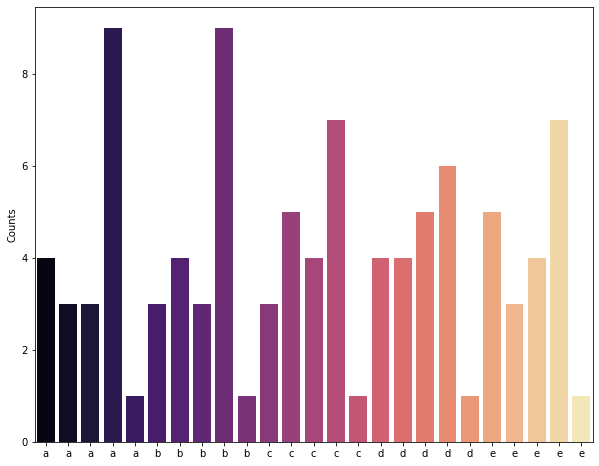

In [20]:
plt.figure(figsize=(10,8))
sns.barplot(counts.index, 'Counts',   data=counts, palette='magma')
plt.xticks(counts.index, labels = counts.Task);

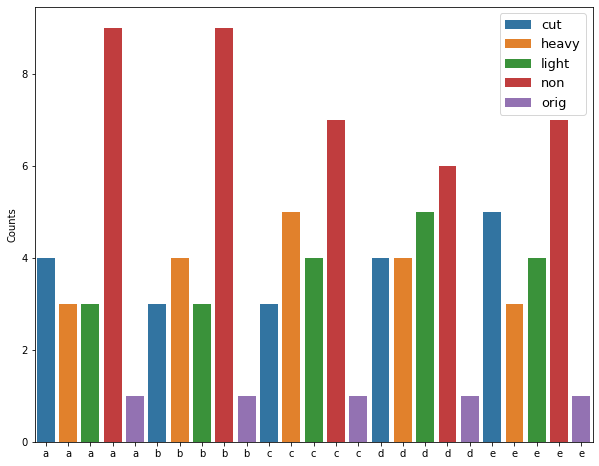

In [21]:
plt.figure(figsize=(10,8))
sns.barplot(counts.index, 'Counts', 'Category',data=counts, dodge=False)
plt.xticks(counts.index, labels = counts.Task)
plt.legend(loc='upper right', fontsize=13);

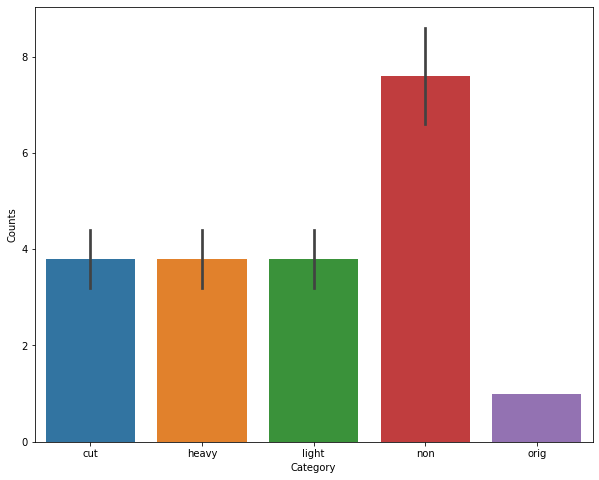

In [22]:
plt.figure(figsize=(10,8))
sns.barplot('Category', 'Counts', data=counts);

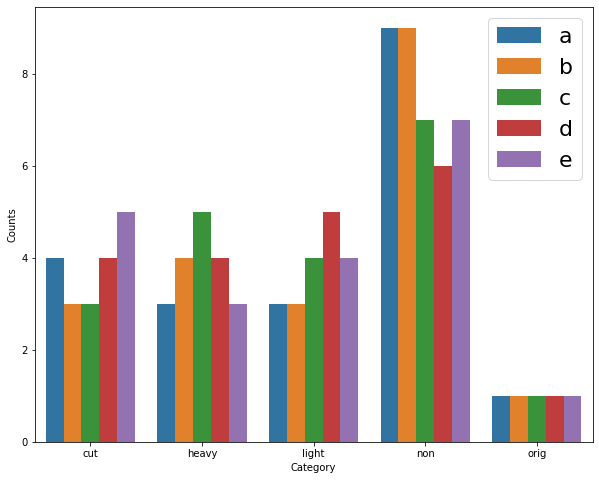

In [23]:
plt.figure(figsize=(10,8))
sns.barplot('Category', 'Counts', 'Task', data=counts,)
plt.legend(fontsize=22);

## Up Next

This notebook is just about data loading and exploration, and you do not need to include it in your final project submission. 

In the next few notebooks, you'll use this data to train a complete plagiarism classifier. You'll be tasked with extracting meaningful features from the text data, reading in answers to different tasks and comparing them to the original Wikipedia source text. You'll engineer similarity features that will help identify cases of plagiarism. Then, you'll use these features to train and deploy a classification model in a SageMaker notebook instance. 